# Regression Analysis

## Does crative features influence on Click Through Rate?

-- Cuáles son los drivers de performance en Paid Social (TikTok)?

In [10]:
import os, json, pandas as pd, numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
import graphviz

In [2]:
df = pd.read_csv('../../data/datasets/tiktok_topads_clean_transformed.csv')
display(df.head())
display(df.tail())

,cost,ctr,like,is_ugc,duration,height,width,high_interaction,industry_parent_Apparel & Accessories,industry_parent_Appliances,...,demographic_representation_Unclear,audience_focus_Others,audience_focus_Problem Aware,audience_focus_Solution Aware,audience_focus_Unclear,campaign_objective_App Promotion,campaign_objective_Awareness,campaign_objective_Others,campaign_objective_Sales,aspect_ratio
0,2,0.01,14299,False,37.334,1024.0,576.0,True,False,False,...,False,True,False,False,False,False,True,False,False,0.5625
1,0,0.02,2427,False,17.323,1024.0,576.0,False,False,False,...,False,True,False,False,False,False,True,False,False,0.5625
2,0,0.02,2739,True,14.016,1024.0,576.0,False,False,False,...,False,True,False,False,False,True,False,False,False,0.5625
3,1,0.02,5491,True,19.318,1280.0,720.0,True,False,False,...,False,True,False,False,False,True,False,False,False,0.5625
4,1,0.03,1811,True,25.250,1280.0,720.0,False,False,False,...,False,True,False,False,False,True,False,False,False,0.5625


,cost,ctr,like,is_ugc,duration,height,width,high_interaction,industry_parent_Apparel & Accessories,industry_parent_Appliances,...,demographic_representation_Unclear,audience_focus_Others,audience_focus_Problem Aware,audience_focus_Solution Aware,audience_focus_Unclear,campaign_objective_App Promotion,campaign_objective_Awareness,campaign_objective_Others,campaign_objective_Sales,aspect_ratio
409,2,0.03,1966,True,58.770,1024.0,576.0,False,False,False,...,False,True,False,False,False,False,False,False,True,0.5625
410,2,0.02,11650,False,71.400,1024.0,576.0,True,False,False,...,True,True,False,False,False,False,True,False,False,0.5625
411,1,0.02,1842,True,109.085,1280.0,720.0,False,True,False,...,False,False,True,False,False,False,False,False,True,0.5625
412,2,0.02,3435,True,129.677,1280.0,720.0,False,True,False,...,False,True,False,False,False,False,False,False,True,0.5625
413,2,0.03,22938,True,21.884,1024.0,576.0,True,True,False,...,False,True,False,False,False,False,False,False,True,0.5625


In [3]:
#!/usr/bin/env python
"""
Reproduces the TikTok CDS-CTR study:
  • Univariate plots  (histogram + mean-by-category bars)
  • Multivariate models (standardised OLS + Random-Forest)
  • OLS-vs-RF scatter
  • First RF tree visualisation
  • Auto-generated PDF summary
"""

'\nReproduces the TikTok CDS-CTR study:\n  • Univariate plots  (histogram + mean-by-category bars)\n  • Multivariate models (standardised OLS + Random-Forest)\n  • OLS-vs-RF scatter\n  • First RF tree visualisation\n  • Auto-generated PDF summary\n'

In [4]:
OUT  = "output"; os.makedirs(OUT, exist_ok=True)

y  = df['ctr'].values
X  = df.drop(columns=['ctr','cost','like','high_interaction'])

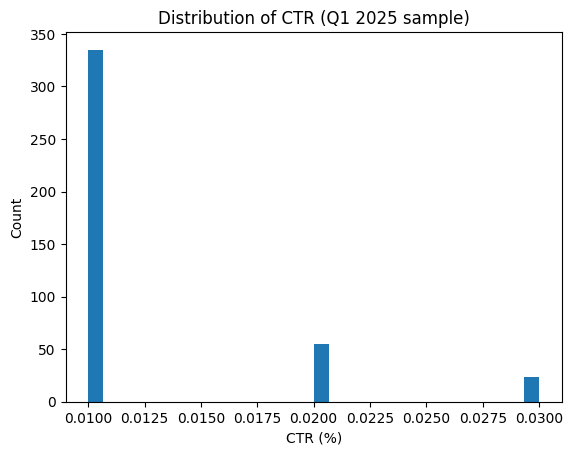

<Figure size 640x480 with 0 Axes>

In [5]:

plt.figure(); plt.hist(y, bins=30); plt.xlabel("CTR (%)"); plt.ylabel("Count")
plt.title("Distribution of CTR (Q1 2025 sample)")
plt.show()
plt.savefig(f"output/ctr_hist.png", dpi=300)

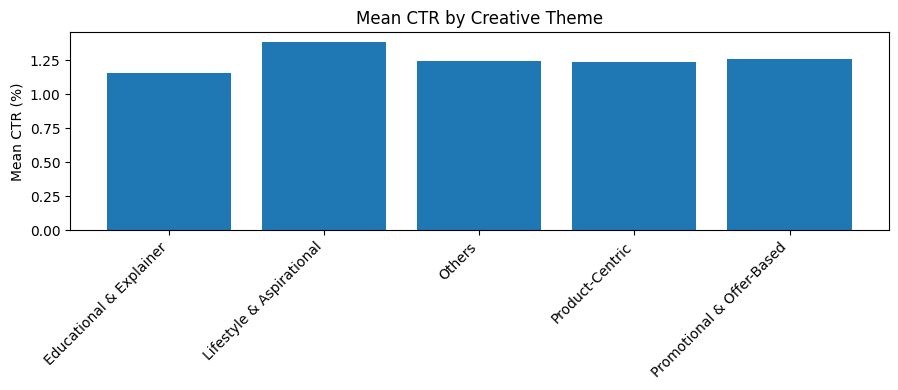

In [6]:
# bar of mean CTR by theme
theme_cols = [c for c in X.columns if c.startswith("creative_theme_")]
theme_mean = {c.replace("creative_theme_",""): y[X[c]==1].mean()*100 for c in theme_cols}
plt.figure(figsize=(9,4)); 
plt.bar(theme_mean.keys(), theme_mean.values()); plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean CTR (%)"); plt.title("Mean CTR by Creative Theme")
plt.tight_layout(); plt.savefig(f"output/theme_bar.png", dpi=300)

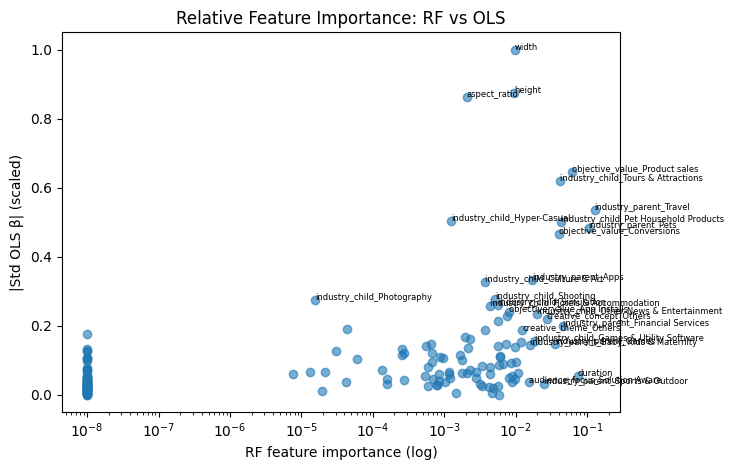

In [8]:
Xs = StandardScaler().fit_transform(X); Xs = sm.add_constant(Xs)
ols = sm.OLS(y, Xs).fit()
beta = np.abs(ols.params[1:])  # exclude intercept

rf  = RandomForestRegressor(n_estimators=500, random_state=42, oob_score=True)
rf.fit(X, y)
imp = rf.feature_importances_

# scatter OLS vs RF
plt.figure(); 
plt.scatter(imp + 1e-8, (beta - beta.min())/(beta.max()-beta.min()), alpha=.6)
plt.xscale('log'); plt.xlabel("RF feature importance (log)"); plt.ylabel("|Std OLS β| (scaled)")
plt.title("Relative Feature Importance: RF vs OLS")
plt.tight_layout(); plt.savefig(f"output/ols_rf_scatter.png", dpi=300)

# annotate top‐right quadrant
for i, txt in enumerate(X.columns):
    if imp[i] > np.percentile(imp,90) or beta[i] > np.percentile(beta,90):
        plt.annotate(txt, (imp[i]+1e-8, (beta[i]-beta.min())/(beta.max()-beta.min())),
                     fontsize=6)

In [12]:
dt = DecisionTreeRegressor(max_depth=3, random_state=0).fit(X, y)
dot = export_graphviz(dt, feature_names=X.columns, filled=True, rounded=True,
                      special_characters=True)
graphviz.Source(dot).render(f"output/rf_tree", format="png", cleanup=True)

'output/rf_tree.png'

## Parametric: linear regression with OLS

### Target = CTR

In [37]:
#I need to cast boolean features to int
df = df * 1

In [38]:
#lets see if there are any non numeric features
print(df.select_dtypes(include='object').columns)
print(df.select_dtypes(include='bool').columns)

Index([], dtype='object')
Index([], dtype='object')


In [ ]:
df['']

In [39]:
# Prepare X (features) and y (target)
y = df['ctr']
X = df.drop(['ctr', 'cost', 'like', 'high_interaction'], axis=1)

# Add constant for intercept
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ctr   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     4.774
Date:                Tue, 27 May 2025   Prob (F-statistic):           1.95e-28
Time:                        10:22:17   Log-Likelihood:                 1814.7
No. Observations:                 414   AIC:                            -3357.
Df Residuals:                     278   BIC:                            -2810.
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [46]:
# Get coefficients and feature names
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.params
})

# Sort by absolute coefficient value
coef_df['abs_coef'] = abs(coef_df['coefficient'])
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Display top coefficients
print("\nTop 10 most influential features:")
print(coef_df.head(10))



Top 10 most influential features:
                                                                                   feature  \
industry_child_Gifts & Flowers                              industry_child_Gifts & Flowers   
industry_child_Kitchen & Bathroom Appliances  industry_child_Kitchen & Bathroom Appliances   
industry_child_Constructional Engineering        industry_child_Constructional Engineering   
aspect_ratio                                                                  aspect_ratio   
industry_child_Pet Toys                                            industry_child_Pet Toys   
industry_child_Financial Services                        industry_child_Financial Services   
industry_child_News & Reading                                industry_child_News & Reading   
industry_child_Gaming Devices                                industry_child_Gaming Devices   
industry_child_Health & Fitness                            industry_child_Health & Fitness   
industry_child_Dating & M

### Target = Likes

In [41]:
# Prepare X (features) and y (target)
y = df['like']
X = df.drop(['ctr', 'cost', 'like', 'high_interaction'], axis=1)

# Add constant for intercept
X = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   like   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1.301
Date:                Tue, 27 May 2025   Prob (F-statistic):             0.0349
Time:                        10:44:30   Log-Likelihood:                -4109.6
No. Observations:                 414   AIC:                             8491.
Df Residuals:                     278   BIC:                             9039.
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## Non-Parametric: tree based regression

In [43]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [45]:
# Prepare X (features) and y (target) 
y = df['ctr']
X = df.drop(['ctr', 'cost', 'like', 'high_interaction'], axis=1)

# Create and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance scores
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})

# Sort features by importance and display top 10
print("Top 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

# Predict on training data
y_pred = rf_model.predict(X)

# Calculate metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")



Top 10 Most Important Features:
                                   feature  importance
23                  industry_parent_Travel    0.126772
20                    industry_parent_Pets    0.102513
1                                 duration    0.078838
136          objective_value_Product sales    0.058789
106  industry_child_Pet Household Products    0.046454
12      industry_parent_Financial Services    0.046347
125     industry_child_Tours & Attractions    0.041763
135            objective_value_Conversions    0.039852
14                   industry_parent_Games    0.036865
21        industry_parent_Sports & Outdoor    0.025670
Mean Squared Error: 0.0000
R-squared: 0.9387


## Mix Analysis 

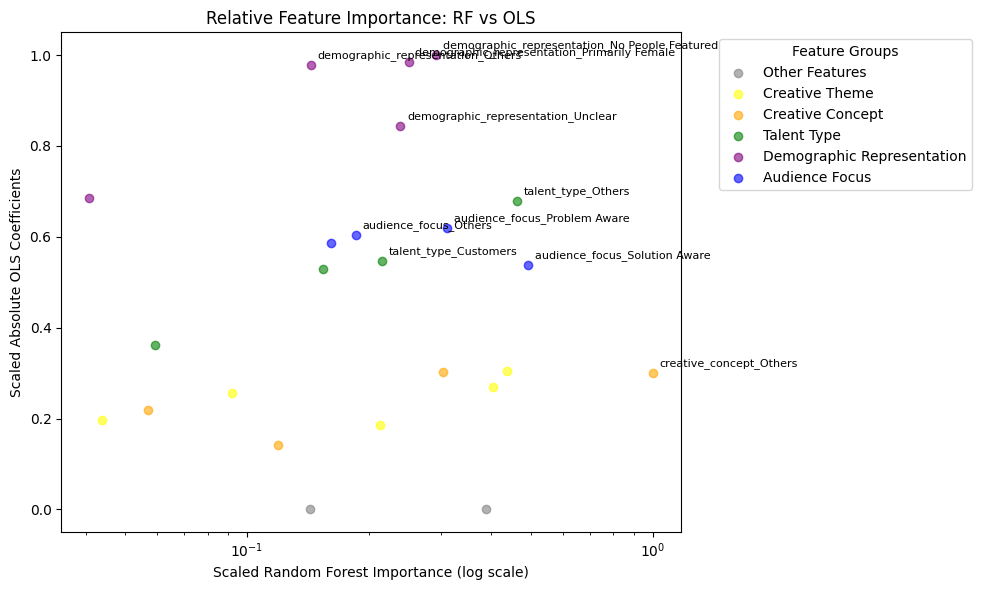

In [63]:
# Get OLS coefficients from previous linear regression
# First need to standardize the data to get comparable coefficients
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit OLS model
from sklearn.linear_model import LinearRegression
ols_model = LinearRegression()
ols_model.fit(X_scaled, y)

# Create dataframe with both importance scores
comparison_df = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_model.feature_importances_,
    'ols_coef': np.abs(ols_model.coef_)  # Take absolute value for comparison
})

# remove features that start with 'industry since they are not relevant for the analysis
comparison_df = comparison_df[
    ~comparison_df['feature'].str.startswith('objective_value_') &
    ~comparison_df['feature'].str.startswith('industry_') &
    ~comparison_df['feature'].str.startswith('campaign_') &
    ~comparison_df['feature'].str.startswith('duration') &
    ~comparison_df['feature'].str.startswith('height') &
    ~comparison_df['feature'].str.startswith('width') 
]

# Putting both on the same scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
comparison_df[['rf_importance_scaled', 'ols_coef_scaled']] = scaler.fit_transform(
    comparison_df[['rf_importance', 'ols_coef']]
)

# Add color coding based on feature groups
def get_feature_group_and_color(feature_name):
    if feature_name.startswith('talent_type_'):
        return 'Talent Type', 'green'
    elif feature_name.startswith('audience_focus_'):
        return 'Audience Focus', 'blue'
    elif feature_name.startswith('creative_concept_'):
        return 'Creative Concept', 'orange'
    elif feature_name.startswith('creative_theme_'):
        return 'Creative Theme', 'yellow'
    elif feature_name.startswith('demographic_representation_'):
        return 'Demographic Representation', 'purple'
    else:
        return 'Other Features', 'gray'

comparison_df['group'], comparison_df['color'] = zip(*comparison_df['feature'].apply(get_feature_group_and_color))

# Calculate average importance and difference for top 10 selection
comparison_df['avg_importance'] = (comparison_df['rf_importance_scaled'] + comparison_df['ols_coef_scaled']) / 2
comparison_df['importance_diff'] = abs(comparison_df['rf_importance_scaled'] - comparison_df['ols_coef_scaled'])
top_10_features = comparison_df.nlargest(10, 'avg_importance')['feature'].tolist()

# Create scatter plot
plt.figure(figsize=(10, 6))

# Plot points by feature group
for group in comparison_df['group'].unique():
    mask = comparison_df['group'] == group
    color = comparison_df[mask]['color'].iloc[0]
    plt.scatter(comparison_df[mask]['rf_importance_scaled'], 
               comparison_df[mask]['ols_coef_scaled'],
               c=color, alpha=0.6, label=group)

# Add labels only for top 10 features
for idx, row in comparison_df.iterrows():
    if row['feature'] in top_10_features:
        plt.annotate(row['feature'], 
                    (row['rf_importance_scaled'], row['ols_coef_scaled']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8)

plt.xlabel('Scaled Random Forest Importance (log scale)')
plt.ylabel('Scaled Absolute OLS Coefficients')
plt.title('Relative Feature Importance: RF vs OLS')
plt.xscale('log')
plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
